In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import scipy
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import torch

cn = plt.matplotlib.colors.CenteredNorm()

def get_dataset(root, n):

    ds_train = torchvision.datasets.MNIST(root, train=True, download=False)
    ds_valid = torchvision.datasets.MNIST(root, train=False, download=False)

    indices = random.sample(range(len(ds_train)), n)

    # Extract random subset for training data
    imgs_train, labels_train = zip(*[(ds_train[idx][0], ds_train[idx][1]) for idx in indices])
    imgs_valid, labels_valid = zip(*[(item[0], item[1]) for item in ds_valid])

    # Put all images in a n x 28*28 matrix
    data_train = np.zeros((len(imgs_train),28*28), dtype=np.float32)
    for idx, img in enumerate(imgs_train):
        data_train[idx] = np.array(img).flatten()

    data_valid = np.zeros((len(imgs_valid),28*28), dtype=np.float32)
    for idx, img in enumerate(imgs_valid):
        data_valid[idx] = np.array(img).flatten()

    # Standardize data
    u = data_train.mean()
    s = data_train.std()
    data_train = normalize(data_train, u, s)
    data_valid = normalize(data_valid, u, s)

    return data_train, labels_train, data_valid, labels_valid

def create_image(model, data, eps=0.1, grid_resolution=300):

    x0, x1 = data.T

    x0_min, x0_max = x0.min() - eps, x0.max() + eps
    x1_min, x1_max = x1.min() - eps, x1.max() + eps

    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    data_grid = np.c_[xx0.ravel(), xx1.ravel()]

    response = model(data_grid)
    response = response.reshape(xx0.shape)

    return response, xx0, xx1

def plot_regions(model, data, labels, grid_resolution=300, eps=0.1):

    #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
    #      '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

    response, xx0, xx1 = create_image(model, data, eps=eps, grid_resolution=grid_resolution)

    fig, ax = plt.subplots(figsize=(7,6))
    co = ax.pcolormesh(xx0, xx1, response, 
                    cmap='tab10', alpha=0.5)
    sc = ax.scatter(*data.T, s=3, c=labels, cmap='tab10')
    fig.colorbar(sc, ax=ax)

def normalize(data, mean=None, std=None):

    if mean is None: mean = data.mean()
    if std is None: std = data.std()
    
    return (data-mean)/std

def cross_entropy(estimator, data, labels):
    logs = estimator.predict_log_proba(data)
    logs_c = -logs[range(len(logs)), labels]

    return logs_c.mean()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

data_train, labels_train, data_valid, labels_valid = get_dataset(root, n)

Accuracy: 89.68
Cross entropy: 0.7007149433761526


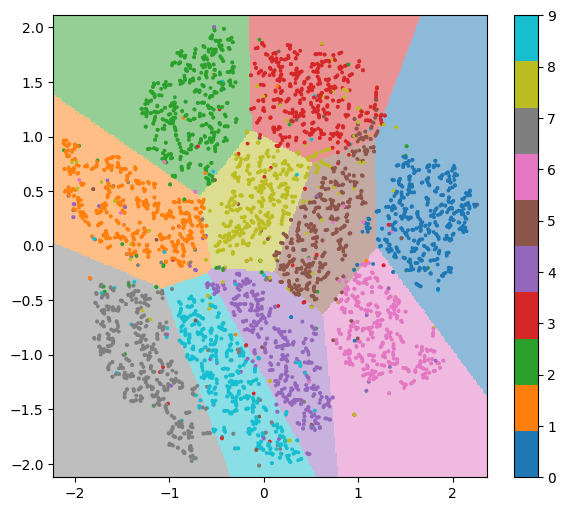

In [2]:
# 2D projection using t-SNE and logistic regression
mapper = TSNE(perplexity=7, learning_rate='auto')
proj_tsne = mapper.fit_transform(data_train)
proj_tsne = normalize(proj_tsne)
labels_train
logreg = LogisticRegression(C=1000)
logreg.fit(proj_tsne, labels_train)

print('Accuracy:', 100*logreg.score(proj_tsne, labels_train))
print('Cross entropy:', cross_entropy(logreg, proj_tsne, labels_train))

plot_regions(logreg.predict, proj_tsne, labels_train)

## Model interpretation

In [8]:
logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(data_train, labels_train)
print('Train accuracy:', logreg.score(data_train, labels_train))
print('Valid accuracy:', logreg.score(data_valid, labels_valid))

Train accuracy: 0.9844
Valid accuracy: 0.8985


In [9]:
def create_model(logreg):

    model = torch.nn.Linear(28*28, 10)
    model.requires_grad_(False)
    model.weight[:] = torch.tensor(logreg.coef_)
    model.bias[:] = torch.tensor(logreg.intercept_)

    return model

model = create_model(logreg)
data_train_pt = torch.tensor(data_train)
labels_train_pt = torch.tensor(labels_train)

logits = model(data_train_pt)
pred = logits.argmax(dim=1)
acc = (labels_train_pt==pred).sum()/len(labels_train_pt)
print('Accuracy:', 100*acc.item())

Accuracy: 98.43999743461609


### Logistic weights

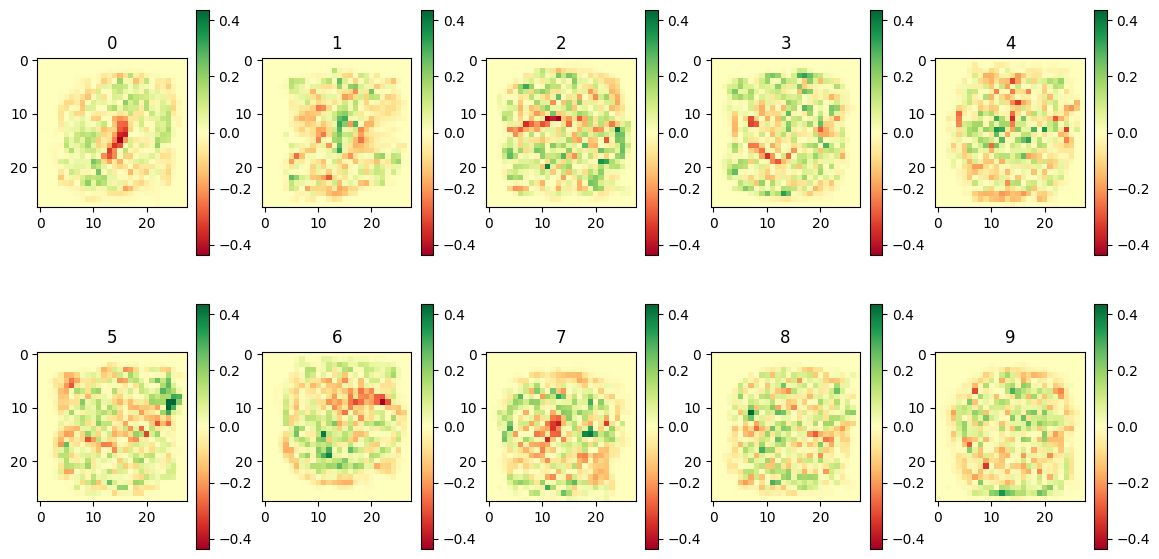

In [11]:
cn = plt.matplotlib.colors.CenteredNorm()
plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)


### Attributions for an image

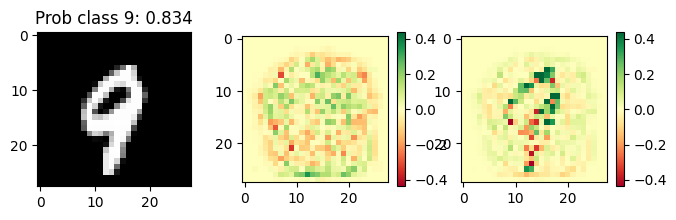

In [14]:
idx = 0
label = labels_train_pt[idx]

x = data_train_pt[idx]
img = x.reshape(28,28)
weight = model.weight[label].reshape(28,28)
prob = model(x[None]).softmax(dim=1)[0][label]

plt.figure(figsize=(8,2))
plt.subplot(1, 3, 1)
plt.imshow(img, 'gray')
plt.title(f'Prob class {label}: {prob:.3f}')
plt.subplot(1, 3, 2)
plt.imshow(weight, 'RdYlGn', norm=cn)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(weight*img, 'RdYlGn', norm=cn)
plt.colorbar()

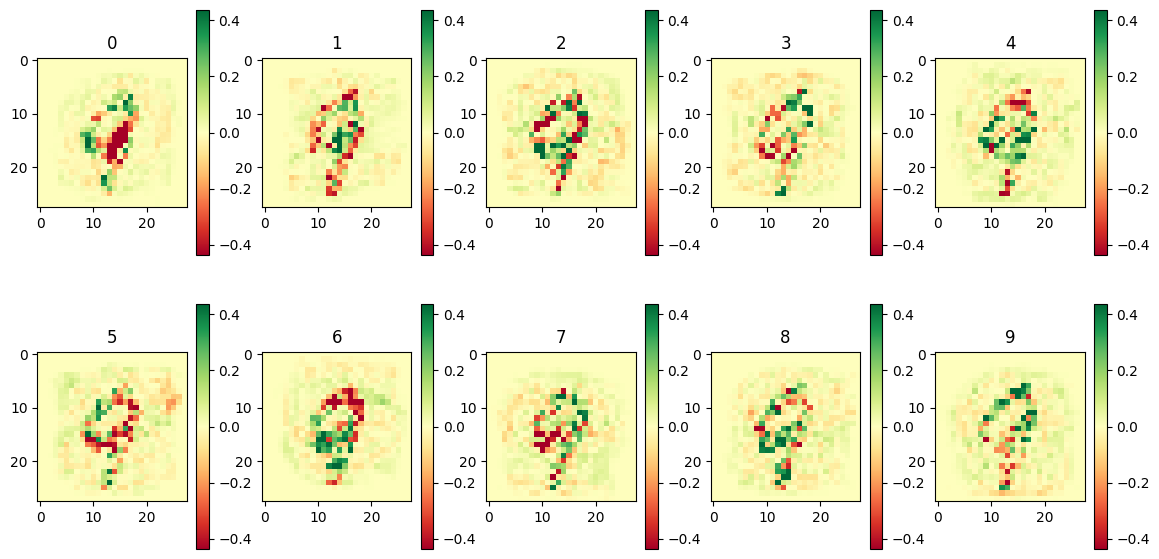

In [15]:
plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[idx].reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions

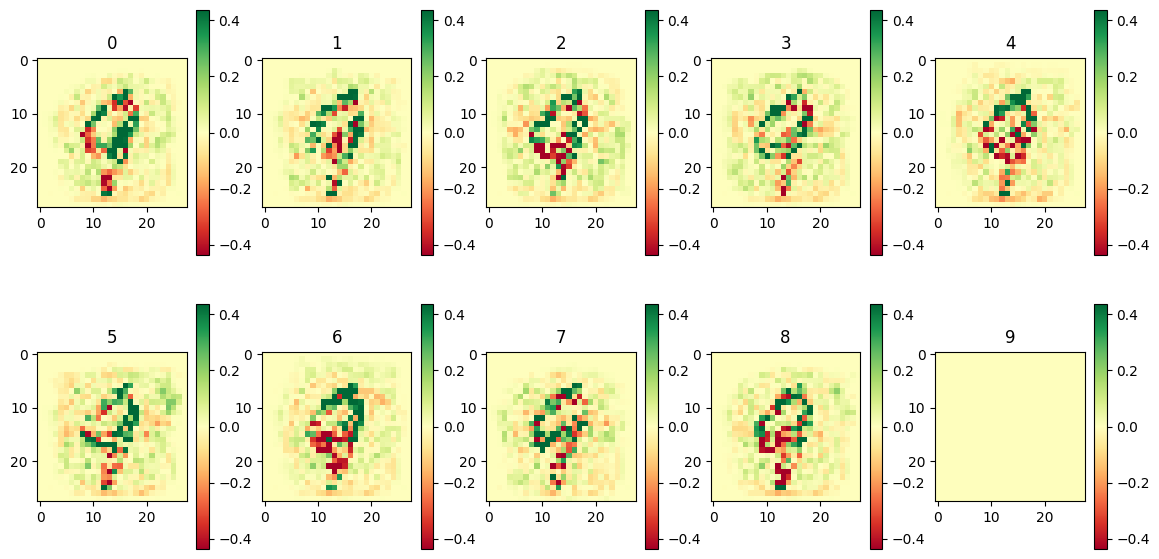

In [17]:
plt.figure(figsize=(14, 7))
for idx in range(10):
    # Get weights that contributed to classify to class label instead of idx
    weight = model.weight[label] - model.weight[idx] 
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*img, 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### 2-class attributions considering class prototypes

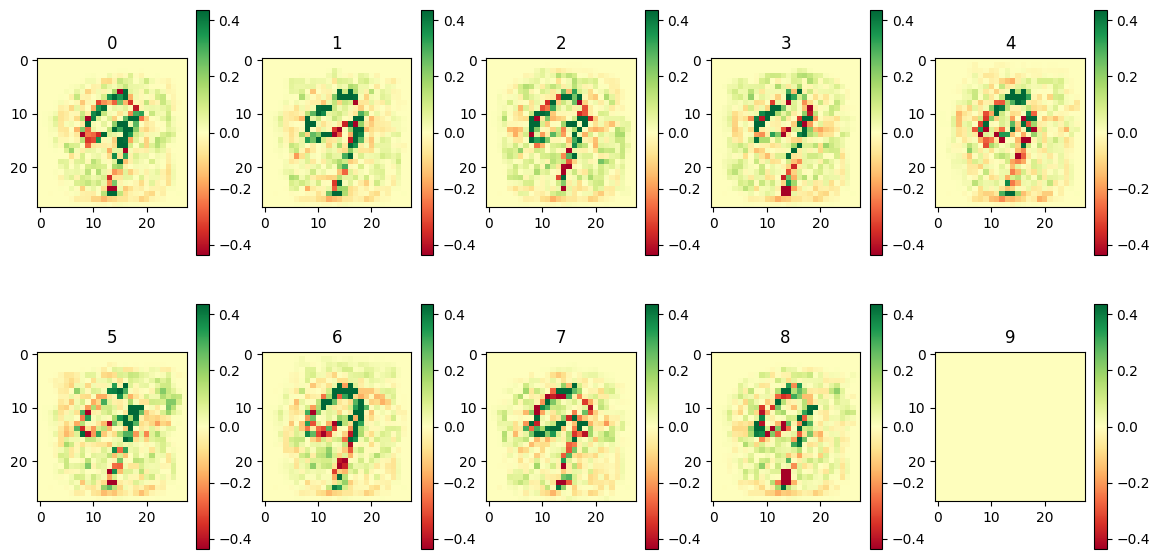

In [19]:
from scipy.spatial import KDTree

# Find samples at the center of each class (warning, average might not be at the peak of the distribution)
tree = KDTree(data_train)
imgs = []
for idx in range(10):
    mean = data_train[np.array(labels_train)==idx].mean(axis=0)
    d, sample_idx = tree.query(mean)
    imgs.append(data_train[sample_idx].reshape(28,28))

plt.figure(figsize=(14, 7))
for idx in range(10):
    weight = model.weight[9] - model.weight[idx]
    weight = weight.reshape(28,28)
    plt.subplot(2, 5, idx+1)
    plt.imshow(weight*imgs[9], 'RdYlGn', norm=cn)
    plt.colorbar()
    plt.title(idx)

### Random experiments

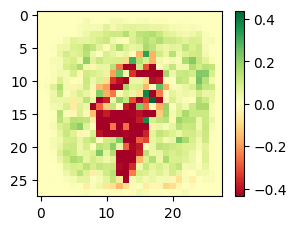

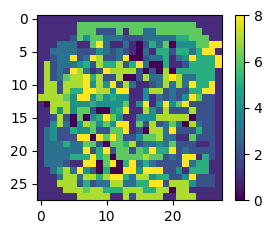

In [82]:
weight0 = model.weight[0].reshape(28,28)
weight4 = model.weight[4].reshape(28,28)
weight7 = model.weight[7].reshape(28,28)
weight9 = model.weight[9].reshape(28,28)
weight_mean = model.weight[:9].mean(dim=0).reshape(28,28)
weight_max, weights_max_ind = model.weight[:9].max(dim=0)
weight_max = weight_max.reshape(28, 28)
weights_max_ind = weights_max_ind.reshape(28, 28)

plt.imshow((weight9-weight_max)*img, 'RdYlGn', norm=cn)
plt.colorbar()
plt.figure()
plt.imshow(weights_max_ind)
plt.colorbar()

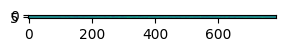

In [84]:
plt.imshow(model.weight)

In [13]:
import torch
from torch.masked import masked_tensor, as_masked_tensor
import warnings

# Disable prototype warnings and such
warnings.filterwarnings(action='ignore', category=UserWarning)

x = torch.tensor([1., 2., 3., 4., 5., 6.])
mask = torch.tensor([0., 0., 1., 1., 0., 0.], dtype=bool)

conv = torch.nn.Conv1d(1, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = 1.
    conv.bias[:] = 0.